# Test grader
https://www.pyimagesearch.com/2016/10/03/bubble-sheet-multiple-choice-scanner-and-test-grader-using-omr-python-and-opencv/

In [1]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 20, 15

## Configuration

In [2]:
image_path = 'images/test_01.png'

# Define the answer key which maps the question number to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

## Process image

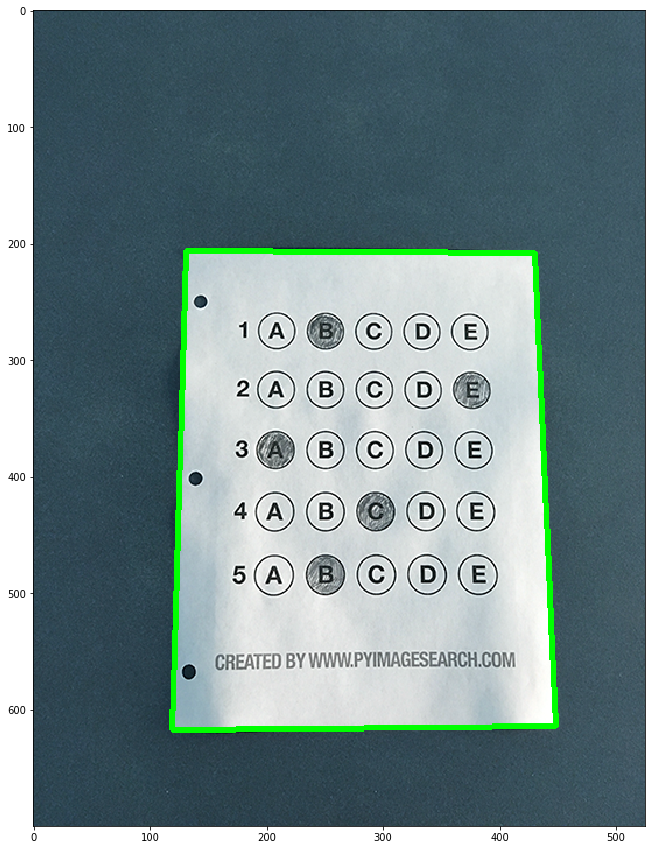

In [3]:
# Load the image, convert it to grayscale, blur it slightly, then find edges
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

# Find contours in the edge map, then initialize the contour that corresponds to the document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

docCnt = None
# Ensure that at least one contour was found
if len(cnts) > 0:
    # Sort the contours according to their size in descending order
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    # Loop over the sorted contours
    for c in cnts:
        # Approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # If our approximated contour has four points, then we can assume we have found the paper
        if len(approx) == 4:
            docCnt = approx
            break
            
# Show detected contour
image_contour = image.copy()
cv2.drawContours(image_contour, [docCnt], -1, (0, 255, 0), 3)
plt.imshow(image_contour)

## Perspective transformation

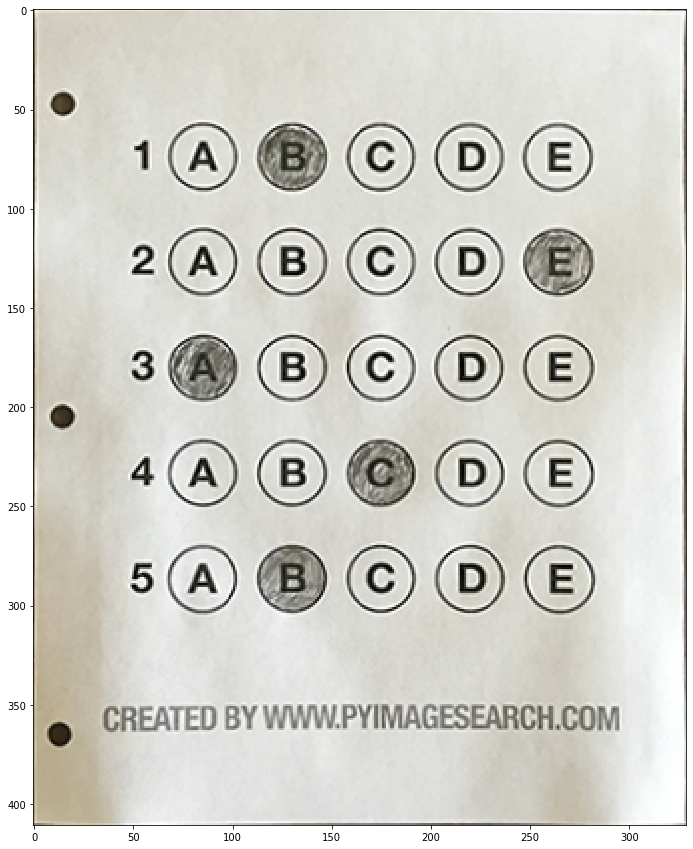

In [4]:
# Apply a four point perspective transform to both the original image and grayscale image
# to obtain a top-down birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

plt.imshow(cv2.cvtColor(paper, cv2.COLOR_BGR2RGB))

## Thresholding

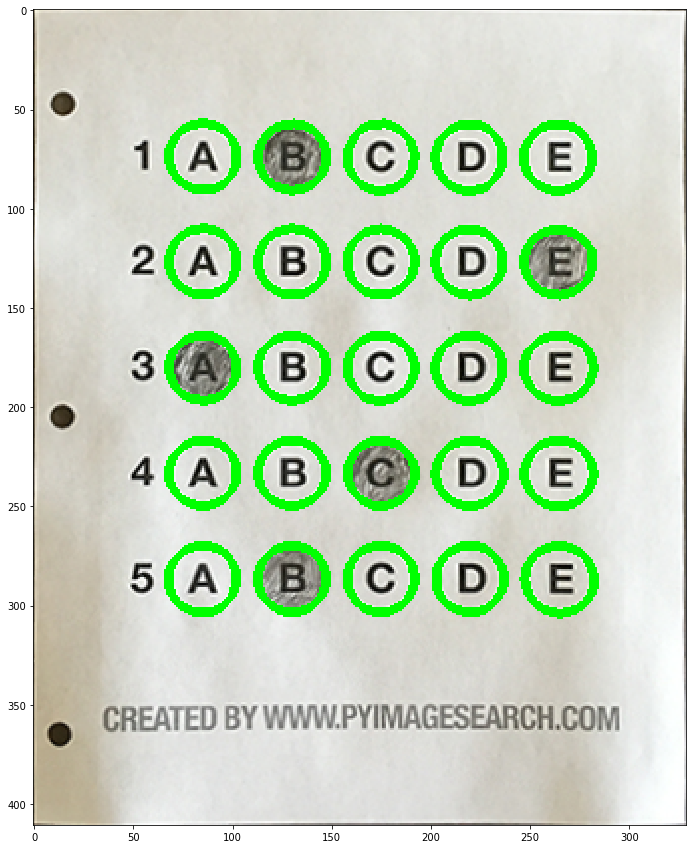

In [5]:
# Apply Otsu's thresholding method to binarize the warped piece of paper
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# Find contours in the thresholded image, then initialize the list of contours that correspond to questions
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

questionCnts = []
# Loop over the contours
for c in cnts:
    # Compute the bounding box of the contour, then use the bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    # In order to label the contour as a question, region should be sufficiently wide,
    # sufficiently tall, and have an aspect ratio approximately equal to 1
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(c)
        
# Show detected question bubbles
image_contour = paper.copy()
cv2.drawContours(image_contour, questionCnts, -1, (0, 255, 0), 3)
image_contour = cv2.cvtColor(image_contour, cv2.COLOR_BGR2RGB)
plt.imshow(image_contour)

## Grade the test

In [6]:
# Sort the question contours top-to-bottom, then initialize the total number of correct answers
questionCnts = contours.sort_contours(questionCnts, method="top-to-bottom")[0]
correct = 0
# Each question has 5 possible answers, to loop over the question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    # Sort the contours for the current question from left to right,
    # then initialize the index of the bubbled answer
    cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
    bubbled = None
    
    # Loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # Construct a mask that reveals only the current "bubble" for the question
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        # Apply the mask to the thresholded image, then count the number of non-zero
        # pixels in the bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)
        # If the current total has a larger number of total non-zero pixels, then we
        # are examining the currently bubbled-in answer
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)
            
    # Initialize the contour color and the index of the *correct* answer
    color = (0, 0, 255)
    k = ANSWER_KEY[q]
    # Check to see if the bubbled answer is correct
    if k == bubbled[1]:
        color = (0, 255, 0)
        correct += 1
    # Draw the outline of the correct answer on the test
    cv2.drawContours(paper, [cnts[k]], -1, color, 3)

Score: 80.00%


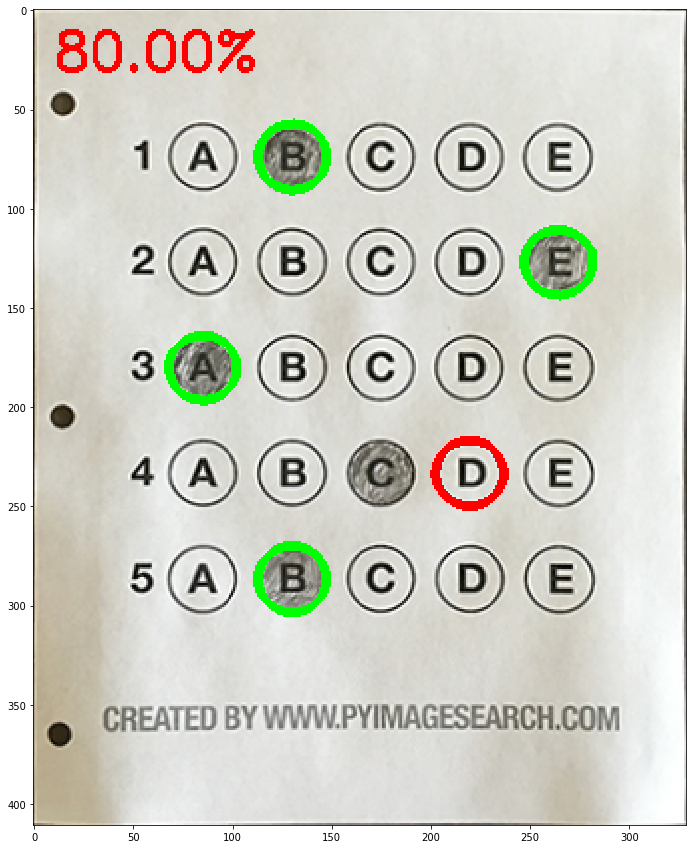

In [7]:
# Grade the test taker
score = (correct / 5.0) * 100
print("Score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
plt.imshow(cv2.cvtColor(paper, cv2.COLOR_BGR2RGB))